## Data Analysis

Goal is to find which variables might be in common between students with low grades (less than 10)

This is done by answering the following hypotheses:

1. There is a high correlation between the partial grades and the final grade
2. Most students are healthy, social and do not drink alcohol during the week but a bit during weekends
3. Students having a parent who is at home have a passing average (average final_grade > 10)
4. The higher the parent's education, the higher the final grade average
5. Students with higher grades study more than the ones with lower grades
6. Travel time has a negative impact on grades
7. The school supports a more significant portion of failing students than passing students

In [1]:
# Import libraries (copy from Syllabus)
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import plotly.express as px
import seaborn as sns
from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
from statsmodels.formula.api import ols
np.random.seed(13)

In [2]:
# Import data types file
typesmath = pd.read_csv('./data/dtypes_math.csv', 
                    index_col=0).to_dict()['0']

In [3]:
# Import dataset
math_df = pd.read_csv('./data/math.csv')

for col, dtype in typesmath.items():
    math_df[col] = math_df[col].astype(dtype)

In [4]:
# Validation of data types
math_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   student_id             395 non-null    int64   
 1   school                 395 non-null    category
 2   sex                    395 non-null    category
 3   age                    395 non-null    float64 
 4   address_type           395 non-null    category
 5   family_size            395 non-null    float64 
 6   parent_status          395 non-null    category
 7   mother_education       395 non-null    float64 
 8   father_education       395 non-null    float64 
 9   mother_job             395 non-null    category
 10  father_job             395 non-null    category
 11  school_choice_reason   395 non-null    category
 12  guardian               395 non-null    category
 13  travel_time            395 non-null    float64 
 14  study_time             395 non-null    flo

In [5]:
# Check some sample
math_df.sample(5)

,student_id,school,sex,age,address_type,family_size,parent_status,mother_education,father_education,mother_job,...,family_relationship,free_time,social,weekday_alcohol,weekend_alcohol,health,absences,grade_1,grade_2,final_grade
300,301,GP,F,18.0,Urban,0.0,Apart,4.0,4.0,health,...,4.0,2.0,4.0,1.0,1.0,4.0,14.0,12.0,10.0,11.0
44,45,GP,F,16.0,Urban,0.0,Living together,2.0,2.0,other,...,4.0,3.0,3.0,2.0,2.0,5.0,14.0,10.0,10.0,9.0
152,153,GP,F,15.0,Rural,1.0,Living together,3.0,3.0,services,...,4.0,2.0,1.0,2.0,3.0,3.0,8.0,10.0,10.0,10.0
61,62,GP,F,16.0,Urban,1.0,Living together,1.0,1.0,services,...,5.0,5.0,5.0,5.0,5.0,5.0,6.0,10.0,8.0,11.0
252,253,GP,M,18.0,Urban,1.0,Living together,2.0,1.0,services,...,3.0,2.0,5.0,2.0,5.0,5.0,4.0,6.0,9.0,8.0


# Correlations 

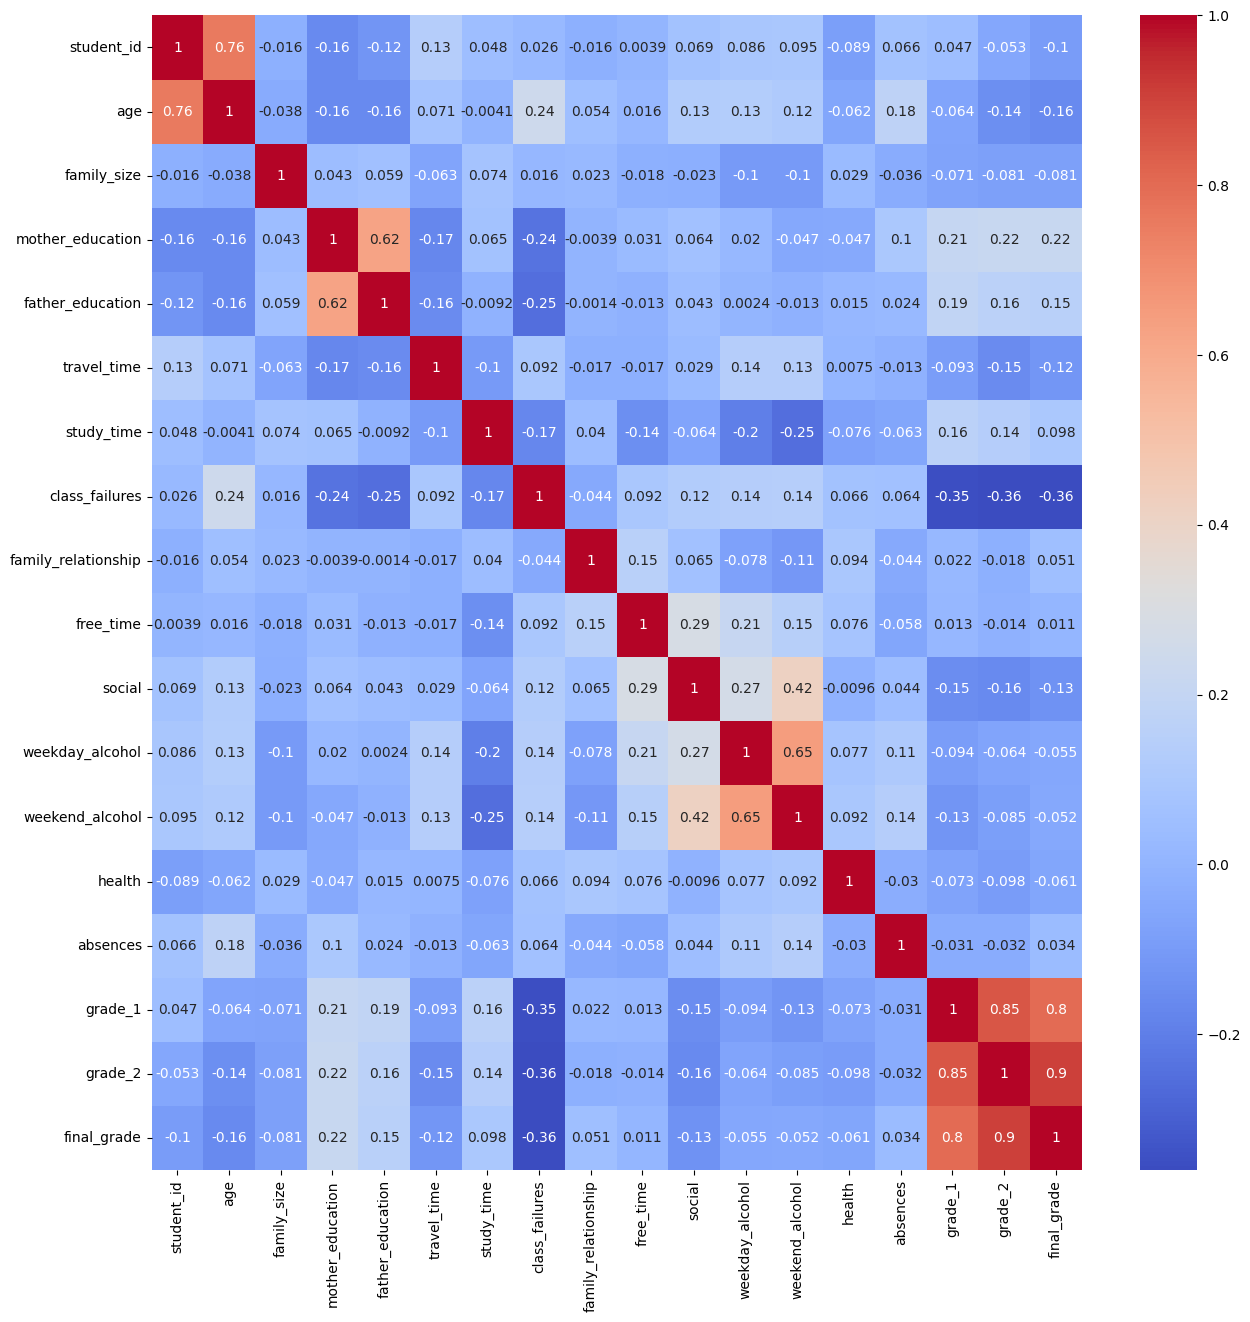

In [9]:
# Correlation between numerical variables
plt.figure(figsize=(15,15))
sns.heatmap(math_df.select_dtypes(np.number).
            corr(), annot=True, cmap='coolwarm');

In [10]:
# Save shape of the float type variables
num = math_df.select_dtypes("float64")
num.shape

(395, 17)

In [11]:
# Check correlation with the final grade
num.corrwith(num["final_grade"]).sort_values().reset_index(name="Correlation").style.background_gradient()

,index,Correlation
0,class_failures,-0.360415
1,age,-0.161579
2,social,-0.132791
3,travel_time,-0.117142
4,family_size,-0.081407
5,health,-0.061335
6,weekday_alcohol,-0.054660
7,weekend_alcohol,-0.051939
8,free_time,0.011307
9,absences,0.034247


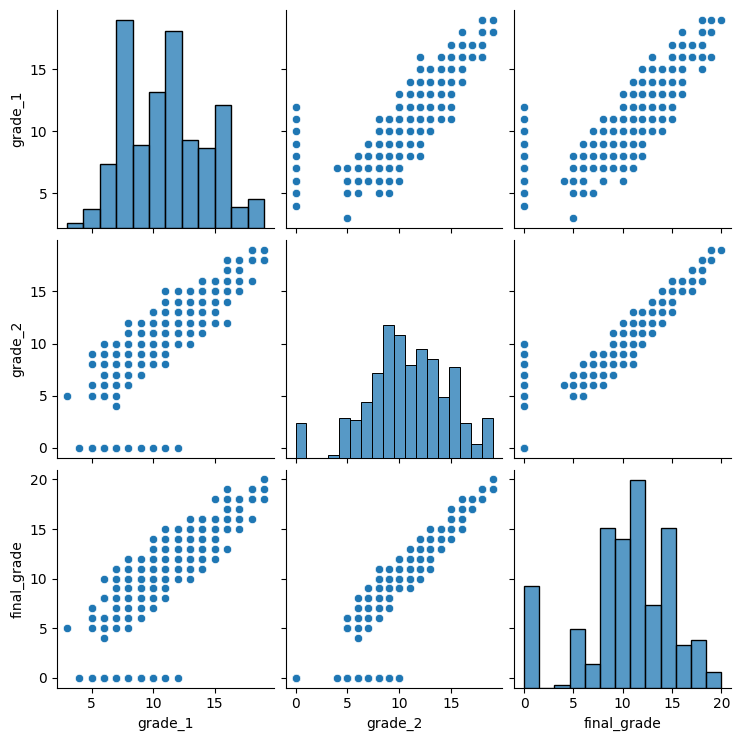

In [13]:
# Deeper look at the link between and within grades
g=sns.pairplot(math_df, vars=['grade_1', 
                'grade_2', 'final_grade'])

- A high positive correlation exists between the partial and final grades
- The other variables do not have a direct impact on grades and should be looked into on a deeper level

<Axes: >

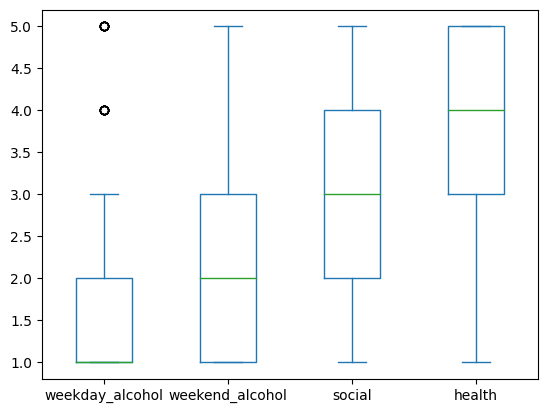

In [12]:
# Boxplot of some variables
math_df[['weekday_alcohol', 
                 'weekend_alcohol','social', 'health']].plot(kind='box')

In [74]:
pivot_table = math_df.pivot_table(index=
            'health', values='final_grade', 
            aggfunc=['mean','count'])
pivot_table

,mean,count
,final_grade,final_grade
health,,
1.0,11.872340,47
2.0,10.222222,45
3.0,10.010989,91
4.0,10.106061,66
5.0,10.397260,146


In [75]:
pivot_table = math_df.pivot_table(index=
            'social', values='final_grade', 
            aggfunc=['mean','count'])
pivot_table

,mean,count
,final_grade,final_grade
social,,
1.0,9.869565,23
2.0,11.194175,103
3.0,10.961538,130
4.0,9.651163,86
5.0,9.037736,53


In [76]:
pivot_table = math_df.pivot_table(index=
            'weekend_alcohol', values='final_grade', 
            aggfunc=['mean','count'])
pivot_table

,mean,count
,final_grade,final_grade
weekend_alcohol,,
1.0,10.735099,151
2.0,10.082353,85
3.0,10.725000,80
4.0,9.686275,51
5.0,10.142857,28


In [77]:
pivot_table = math_df.pivot_table(index=
            'weekday_alcohol', values='final_grade', 
            aggfunc=['mean','count'])
pivot_table

,mean,count
,final_grade,final_grade
weekday_alcohol,,
1.0,10.731884,276
2.0,9.253333,75
3.0,10.500000,26
4.0,9.888889,9
5.0,10.666667,9


- 75% of the students define themselves as healthy (>= 3.0)
- Only half of the students consider themselves as social
- More than 25% drink a bit of alcohol during the week, and over 25% rate their alcohol consumption during the weekend as higher than 3.0
- Students having an above-average social life have the lowest average final grade

Text(0.5, 1.0, "Mother's job")

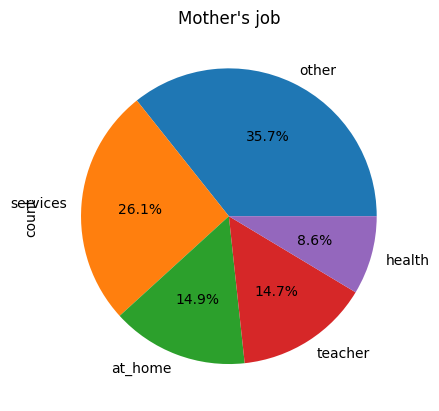

In [7]:
# Overview mother's job
math_df['mother_job'].value_counts().plot(kind='pie',autopct='%1.1f%%');
plt.title("Mother's job")

Text(0.5, 1.0, "Father's job")

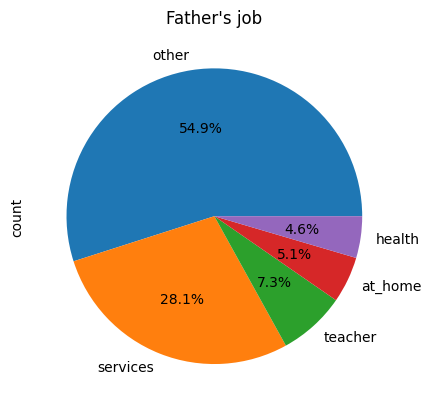

In [8]:
# Overview father's job
math_df['father_job'].value_counts().plot(kind='pie',autopct='%1.1f%%');
plt.title("Father's job")

In [16]:
# Pivot table about the mother's job and the child's final grade
pivot_table = math_df.pivot_table(index=
            'mother_job', values='final_grade', 
            aggfunc=['mean','count'])
pivot_table

,mean,count
,final_grade,final_grade
mother_job,,
at_home,9.152542,59
health,12.147059,34
other,9.822695,141
services,11.019417,103
teacher,11.051724,58


In [17]:
# Pivot table about the father's job and the child's final grade
pivot_table = math_df.pivot_table(index=
            'father_job', values='final_grade', 
            aggfunc=['mean','count'])
pivot_table

,mean,count
,final_grade,final_grade
father_job,,
at_home,10.150000,20
health,11.611111,18
other,10.193548,217
services,10.297297,111
teacher,11.965517,29


- Students with a stay-at-home parent have the lowest final grade average
- Students having parents working in the healthcare and or as teachers have the best average results 


In [14]:
# Pivot table about the mother's education and the child's final grade
pivot_table = math_df.pivot_table(index=
            'mother_education', values='final_grade', 
            aggfunc=['mean','count'])
pivot_table

,mean,count
,final_grade,final_grade
mother_education,,
0.0,13.000000,3
1.0,8.677966,59
2.0,9.728155,103
3.0,10.303030,99
4.0,11.763359,131


In [15]:
# Pivot table about the father's education and the child's final grade
pivot_table = math_df.pivot_table(index=
            'father_education', values='final_grade', 
            aggfunc=['mean','count'])
pivot_table

,mean,count
,final_grade,final_grade
father_education,,
0.0,13.000000,2
1.0,9.158537,82
2.0,10.260870,115
3.0,10.660000,100
4.0,11.364583,96


- Not taking into account 0.0 as both have a count less than 10, which is not representative
- The higher the education, the higher the average passing grade 
- The education of the mother has a higher impact than the education of the father

In [62]:
# Pivot table about the mother's job and education and the child's final grade
ed1 = pd.DataFrame(math_df.groupby(['mother_job','mother_education'])
             ['final_grade'].aggregate(['mean','count']))
ed1 = ed1[ed1['count'] > 10]
ed1

mean  count
mother_job mother_education                  
at_home    1.0                9.680000     25
           2.0                9.045455     22
health     4.0               12.961538     26
other      1.0                7.714286     28
           2.0                9.723404     47
           3.0               10.627907     43
           4.0               10.909091     22
services   2.0               10.281250     32
           3.0               10.750000     40
           4.0               12.692308     26
teacher    4.0               11.145455     55

In [63]:
# Pivot table about the father's job and education and the child's final grade
ed2= pd.DataFrame(math_df.groupby(['father_job','father_education'])
             ['final_grade'].aggregate(['mean','count']))
ed2 = ed2[ed2['count'] > 10]
ed2

mean  count
father_job father_education                  
health     4.0               11.454545     11
other      1.0                8.771930     57
           2.0               10.521739     69
           3.0               10.362069     58
           4.0               11.580645     31
services   1.0                9.368421     19
           2.0                9.558824     34
           3.0               11.000000     35
           4.0               11.086957     23
teacher    4.0               11.777778     27

- Generally, the average final grade is higher when the education of that parent is high within each job
- The exemptions are within the stay-at-home moms and the fathers having a job in the other category when they have a secondary or a 5th to 9th grade education

In [19]:
# Separating two subsets depending on grades
top = math_df[math_df["final_grade"] >= 15]
low=math_df[math_df["final_grade"] < 10]

[Text(0, 0, '<2 hours'),
 Text(1, 0, '2 to 5 hours'),
 Text(2, 0, '5 to 10 hours'),
 Text(3, 0, '>10 hours')]

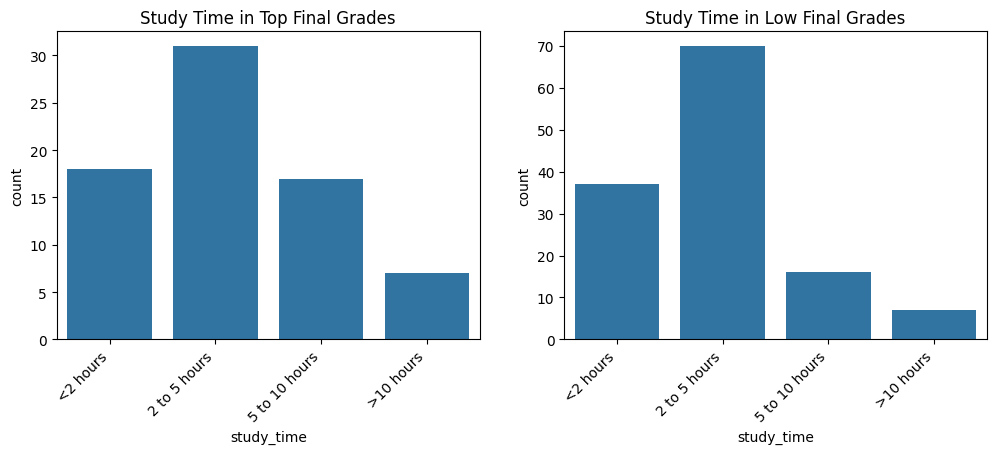

In [45]:
# Barchart of study time for both best students and failing students
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.countplot(data=top, x="study_time", order=[0.0, 1.0, 2.0, 3.0], ax=ax[0])
ax[0].set_title("Study Time in Top Final Grades")
ax[0].set_xticklabels(['<2 hours', '2 to 5 hours', '5 to 10 hours', '>10 hours'], rotation=45, horizontalalignment='right')

sns.countplot(data=low, x="study_time", order=[0.0, 1.0, 2.0, 3.0], ax=ax[1])
ax[1].set_title("Study Time in Low Final Grades")
ax[1].set_xticklabels(['<2 hours', '2 to 5 hours', '5 to 10 hours', '>10 hours'], rotation=45, horizontalalignment='right')

In [29]:
# Pivot table about  study time and final grade
pivot_table = math_df.pivot_table(index=
            'study_time', values='final_grade', 
            aggfunc=['mean','count'])
pivot_table

,mean,count
,final_grade,final_grade
study_time,,
0.0,10.047619,105
1.0,10.171717,198
2.0,11.400000,65
3.0,11.259259,27


In [66]:
# Pivot table about  study time and final grade of the best students
pivot_table = top.pivot_table(index=
            'study_time', values='final_grade', 
            aggfunc=['mean','count'])
pivot_table

,mean,count
,final_grade,final_grade
study_time,,
0.0,16.500000,18
1.0,15.903226,31
2.0,16.176471,17
3.0,17.000000,7


In [31]:
# Pivot table about  study time and final grade of the failing students
pivot_table = low.pivot_table(index=
            'study_time', values='final_grade', 
            aggfunc=['mean','count'])
pivot_table

,mean,count
,final_grade,final_grade
study_time,,
0.0,4.756757,37
1.0,5.842857,70
2.0,5.312500,16
3.0,4.285714,7


- We can see that a higher percentage of top students study more than 5 hours
- When looking at the general dataset, the best results are obtained when studying for 5 to 10 hours
- Not taking into account counts lower than 10, top students have the best average results when studying less than 2 hours, and failing students have the best average results when studying 2 to 5 hours


[Text(0, 0, '<15 min.'),
 Text(1, 0, '15 to 30 min.'),
 Text(2, 0, '30 min\nto 1 hour'),
 Text(3, 0, '>1 hour')]

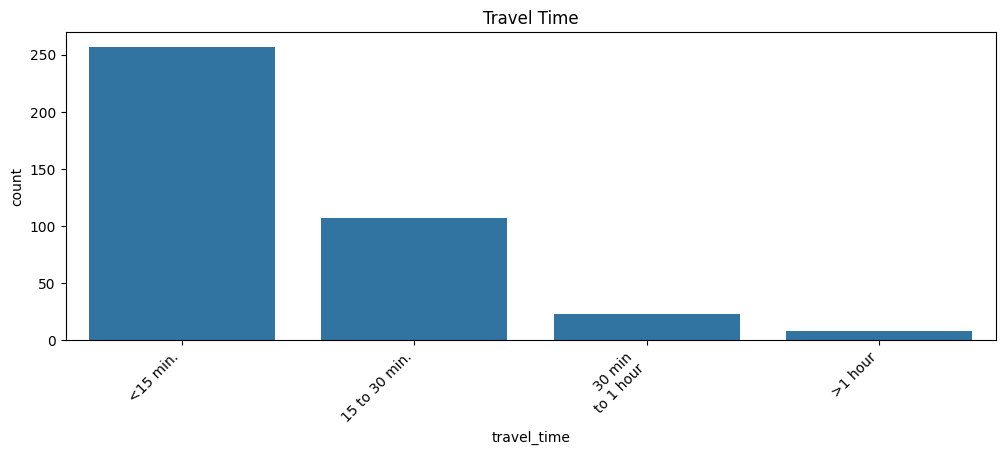

In [70]:
# Barchart of travel time
fig, ax = plt.subplots(figsize=(12, 4))
sns.countplot(data=math_df, x="travel_time", order=[0.0, 1.0, 2.0, 3.0], ax=ax)
ax.set_title("Travel Time")
ax.set_xticklabels(['<15 min.','15 to 30 min.' , '30 minto 1 hour', '>1 hour'], rotation=45, horizontalalignment='right')

In [52]:
# Pivot table about travel time and final grade
pivot_table = math_df.pivot_table(index=
            'travel_time', values='final_grade', 
            aggfunc=['mean','count'])
pivot_table

,mean,count
,final_grade,final_grade
travel_time,,
0.0,10.782101,257
1.0,9.906542,107
2.0,9.260870,23
3.0,8.750000,8


- The lower the travel time, the higher the average final grade

[Text(0, 0, 'yes'), Text(1, 0, 'no')]

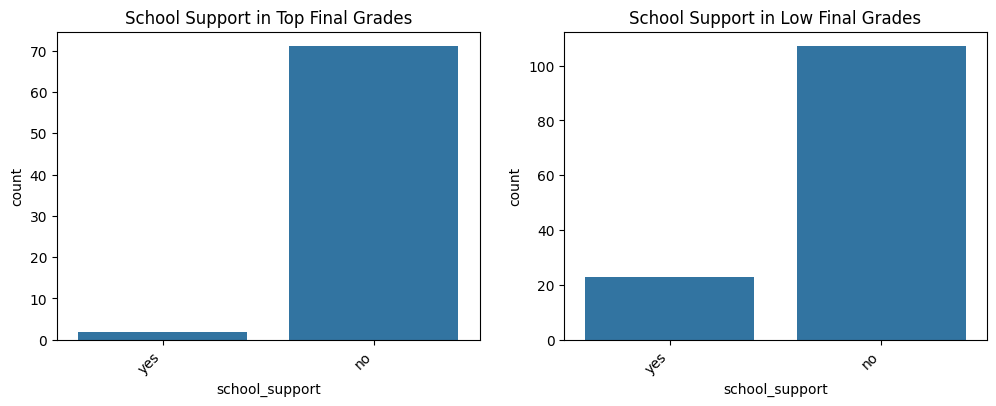

In [24]:
# Barchart of schoolsupport for both best students and failing students
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.countplot(data=top, x="school_support", order=["yes", "no"], ax=ax[0])
ax[0].set_title("School Support in Top Final Grades")
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right')

sns.countplot(data=low, x="school_support", order=["yes", "no"], ax=ax[1])
ax[1].set_title("School Support in Low Final Grades")
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right')

## Hypotheses Evaluation & Conclusion

As there is a high positive correlation between the partial and final grades, partial grade 1 is a good indicator of whether additional support is needed. <br>
The social aspect of students is quite concerning as half of them report a lower-than-average social life, however having a higher-than-average social life is linked to having lower-average final grades. Furthermore, the consumption of alcohol is higher than predicted, with 25% of the students having a high or very high consumption rate during weekends. In general, health and alcohol consumption can not be linked to the students' grades.  <br>
Students having a stay-at-home parent generally have a lower final grade, with an average lower than the passing grade. Kids of teachers or health-related jobs have the best average final grade. <br>
The higher the parents' education, the higher the average final grade. Furthermore, the mother's education has a higher impact on their kids' grades. <br>
Contrary to our previous belief studying more does not mean having higher grades. The best average overall is students studying 5 to 10 hours per week. For failing students, 2 to 5 hours a week has the best results; For top students, the highest average is obtained by those studying less than 2 hours. <br>
Travel time has a negative impact on the average final grade. The more students need to travel, the more tired they are, the less time for studying they have, and the less free time they have. <br>
The school supports a higher percentage of failing students than top students. This is more in line with our goal. However, there are a large number of failing students who need support from their schools.